In [1]:
import re
import numpy as np
import time
import matplotlib.pyplot as plt

In [50]:
class DatasetWithHeatmap:
    def __init__(self):
        self.frameid2pos = None
        self.GHmap = None # GHmap means gaze heap map
        self.NUM_ACTION = 18
        self.xSCALE, self.ySCALE = 8, 4 # was 6,3
        self.SCR_W, self.SCR_H = 160*self.xSCALE, 210*self.ySCALE
        self.train_size = 10
        self.HEATMAP_SHAPE = 14
        
    def createGazeHeatmap(self, GAZE_POS_ASC_FILE):
        print("Reading gaze data ASC file, and converting per-frame gaze positions to heat map...")
        self.frameid2pos = self.read_gaze_data_asc_file(GAZE_POS_ASC_FILE)
        self.train_size = len(self.frameid2pos.keys())
        self.GHmap = np.zeros([self.train_size, self.HEATMAP_SHAPE, self.HEATMAP_SHAPE, 1], dtype=np.float32)

        print("Running BIU.convert_gaze_pos_to_heap_map() and convolution...")
        t1 = time.time()
        
        bad_count, tot_count = 0, 0
        for (i,fid) in enumerate(self.frameid2pos.keys()):
            tot_count += len(self.frameid2pos[fid])
            bad_count += self.convert_gaze_pos_to_heap_map(self.frameid2pos[fid], out=self.GHmap[i])
            
        print("Bad gaze (x,y) sample: %d (%.2f%%, total gaze sample: %d)" % (bad_count, 100*float(bad_count)/tot_count, tot_count))    
        print("'Bad' means the gaze position is outside the 160*210 screen")
        
        sigmaH = 28.50 * self.HEATMAP_SHAPE / self.SCR_H
        sigmaW = 44.58 * self.HEATMAP_SHAPE / self.SCR_W
        self.GHmap = self.preprocess_gaze_heatmap(sigmaH, sigmaW, 0).astype(np.float32)
        print(np.count_nonzero(self.GHmap))

        print("Normalizing the train/val heat map...")
        for i in range(len(self.GHmap)):
            SUM = self.GHmap[i].sum()
            if SUM != 0:
                self.GHmap[i] /= SUM

        print("Done. BIU.convert_gaze_pos_to_heap_map() and convolution used: %.1fs" % (time.time()-t1))
        
        
    def read_gaze_data_asc_file(self, fname):
        """ This function reads a ASC file and returns 
            a dictionary mapping frame ID to a list of gaze positions,
            a dictionary mapping frame ID to action """
       
        with open(fname, 'r') as f:
            lines = f.readlines()
        frameid, xpos, ypos = "BEFORE-FIRST-FRAME", None, None
        frameid2pos = {frameid: []}
        frameid2duration = {frameid: None} 
        frameid2action = {frameid: None}
        
        start_timestamp = 0
        scr_msg = re.compile(r"MSG\s+(\d+)\s+SCR_RECORDER FRAMEID (\d+) UTID (\w+)")
        freg = r"[-+]?[0-9]*\.?[0-9]+" # regex for floating point numbers
        gaze_msg = re.compile(r"(\d+)\s+(%s)\s+(%s)" % (freg, freg))
        
        
        for (i,line) in enumerate(lines):
            match_sample = gaze_msg.match(line)
            if match_sample:
                timestamp, xpos, ypos = match_sample.group(1), match_sample.group(2), match_sample.group(3)
                xpos, ypos = float(xpos), float(ypos)
                frameid2pos[frameid].append((xpos,ypos))
                continue
            
            match_scr_msg = scr_msg.match(line)
            if match_scr_msg: # when a new id is encountered
                old_frameid = frameid 
                timestamp, frameid, UTID = match_scr_msg.group(1), match_scr_msg.group(2), match_scr_msg.group(3)
                frameid2duration[old_frameid] = int(timestamp) - start_timestamp 
                start_timestamp = int(timestamp)
                frameid = self.make_unique_frame_id(UTID, frameid)
                frameid2pos[frameid] = []
                frameid2action[frameid] = None
                continue

        if len(frameid2pos) < 1000: # simple sanity check
            print ("Warning: did you provide the correct ASC file? Because the data for only %d frames is detected" % (len(frameid2pos)))
            input("Press any key to continue")

        few_cnt = 0
        for v in frameid2pos.values():
            if len(v) < 10: few_cnt += 1
        print ("Warning:  %d frames have less than 10 gaze samples. (%.1f%%, total frame: %d)" % \
            (few_cnt, 100.0*few_cnt/len(frameid2pos), len(frameid2pos)))
        return frameid2pos

    
    # bg_prob_density seems to hurt accuracy. Better set it to 0
    def preprocess_gaze_heatmap(self, sigmaH, sigmaW, bg_prob_density, debug_plot_result=False):
        from scipy.stats import multivariate_normal
        import tensorflow as tf, keras as K # don't move this to the top, as people who import this file might not have keras or tf
        model = K.models.Sequential()
        model.add(K.layers.Lambda(lambda x: x+bg_prob_density, input_shape=(self.GHmap.shape[1],self.GHmap.shape[2],1)))

        if sigmaH > 0.0 and sigmaW > 0.0:
            lh, lw = int(4*sigmaH), int(4*sigmaW)
            x, y = np.mgrid[-lh:lh+1:1, -lw:lw+1:1] # so the kernel size is [lh*2+1,lw*2+1]
            pos = np.dstack((x, y))
            gkernel=multivariate_normal.pdf(pos,mean=[0,0],cov=[[sigmaH*sigmaH,0],[0,sigmaW*sigmaW]])
            assert gkernel.sum() > 0.95, "Simple sanity check: prob density should add up to nearly 1.0"

            model.add(K.layers.Lambda(lambda x: tf.pad(x,[(0,0),(lh,lh),(lw,lw),(0,0)],'REFLECT')))
            print(gkernel.shape, sigmaH, sigmaW)
            model.add(K.layers.Conv2D(1, kernel_size=gkernel.shape, strides=1, padding="valid", use_bias=False,
                activation="linear", kernel_initializer=K.initializers.Constant(gkernel)))
        else:
            print ("WARNING: Gaussian filter's sigma is 0, i.e. no blur.")
        # The following normalization hurts accuracy. I don't know why. But intuitively it should increase accuracy
        #def GH_normalization(x):
        #    sum_per_GH = tf.reduce_sum(x,axis=[1,2,3])
        #    sum_per_GH_correct_shape = tf.reshape(sum_per_GH, [tf.shape(sum_per_GH)[0],1,1,1])
        #    # normalize values to range [0,1], on a per heap-map basis
        #    x = x/sum_per_GH_correct_shape
        #    return x
        #model.add(K.layers.Lambda(lambda x: GH_normalization(x)))
        
        model.compile(optimizer='rmsprop', # not used
            loss='categorical_crossentropy', # not used
            metrics=None)
        
        print(np.count_nonzero(self.GHmap))
        output=model.predict(self.GHmap, batch_size=500)
        print(np.count_nonzero(output))

        if debug_plot_result:
            print (r"""debug_plot_result is True. Entering IPython console. You can run:
                    %matplotlib
                    import matplotlib.pyplot as plt
                    f, axarr = plt.subplots(1,2)
                    axarr[0].imshow(gkernel)
                    rnd=np.random.randint(output.shape[0]); print "rand idx:", rnd
                    axarr[1].imshow(output[rnd,...,0])""")
            embed()
        
        shape_before, shape_after = self.GHmap.shape, output.shape
        assert shape_before == shape_after, """
        Simple sanity check: shape changed after preprocessing. 
        Your preprocessing code might be wrong. Check the shape of output tensor of your tensorflow code above"""
        return output
    
    def make_unique_frame_id(self, UTID, frameid):
        return (hash(UTID), int(frameid))
    
    def convert_gaze_pos_to_heap_map(self, gaze_pos_list, out):
        h,w = out.shape[0], out.shape[1]
        bad_count = 0
        for (x,y) in gaze_pos_list: 
            try:
                out[int(y/self.SCR_H*h), int(x/self.SCR_W*w)] += 1
            except IndexError: # the computed X,Y position is not in the gaze heat map
                bad_count += 1
        return bad_count
    
    def convert_gaze_pos_list_to_heap_map(self, gaze_pos_list, out):
        h,w = out.shape[0], out.shape[1]
        bad_count = 0
        if(not np.isnan(gaze_pos_list).all()):    
            for j in range(0,len(gaze_pos_list),2):
                x = gaze_pos_list[j]
                y = gaze_pos_list[j+1]
                try:
                    out[int(y/self.SCR_H*h), int(x/self.SCR_W*w)] += 1
                except IndexError: # the computed X,Y position is not in the gaze heat map
                    bad_count += 1
        return bad_count
    
    

In [51]:
class DatasetWithHeatmapFromList:
    def __init__(self):
        # train_imgs, train_lbl, train_fid, train_size, train_weight = None, None, None, None, None
        self.frameid2pos = None
        self.GHmap = None # GHmap means gaze heap map
        self.NUM_ACTION = 18
        self.xSCALE, self.ySCALE = 8, 4 # was 6,3
        self.SCR_W, self.SCR_H = 160*self.xSCALE, 210*self.ySCALE
        self.train_size = 10
        self.HEATMAP_SHAPE = 14
        
    def createGazeHeatmap(self, gaze_coords, heatmap_shape):
        # print("Reading gaze data ASC file, and converting per-frame gaze positions to heat map...")
        self.frameid2pos = self.get_gaze_data(gaze_coords)
        self.train_size = len(self.frameid2pos.keys())
        self.HEATMAP_SHAPE = heatmap_shape
    
        if(heatmap_shape<=7):
            self.HEATMAP_SHAPE *= 2
        self.GHmap = np.zeros([self.train_size, self.HEATMAP_SHAPE, self.HEATMAP_SHAPE, 1], dtype=np.float32)
        
        # print("Running BIU.convert_gaze_pos_to_heap_map() and convolution...")
        t1 = time.time()
        
        bad_count, tot_count = 0, 0
        for (i,fid) in enumerate(self.frameid2pos.keys()):
            tot_count += len(self.frameid2pos[fid])
            bad_count += self.convert_gaze_pos_to_heap_map(self.frameid2pos[fid], out=self.GHmap[i])
            
        # print("Bad gaze (x,y) sample: %d (%.2f%%, total gaze sample: %d)" % (bad_count, 100*float(bad_count)/tot_count, tot_count))    
        # print("'Bad' means the gaze position is outside the 160*210 screen")
        
        sigmaH = 28.50 * self.HEATMAP_SHAPE / self.SCR_H
        sigmaW = 44.58 * self.HEATMAP_SHAPE / self.SCR_W
        self.GHmap = self.preprocess_gaze_heatmap(sigmaH, sigmaW, 0).astype(np.float32)
        # print(np.count_nonzero(self.GHmap))

        if heatmap_shape<=7:
            import scipy.ndimage
            self.GHmap = scipy.ndimage.zoom(self.GHmap, (1, 0.5, 0.5, 1))

        # print("Normalizing the heat map...")
        for i in range(len(self.GHmap)):
            SUM = self.GHmap[i].sum()
            if SUM != 0:
                self.GHmap[i] /= SUM

        # print("Done. BIU.convert_gaze_pos_to_heap_map() and convolution used: %.1fs" % (time.time()-t1))
        if not np.count_nonzero(self.GHmap):
            print('The gaze map is all zeros')
            

        return self.GHmap
    
    def get_gaze_data(self, gaze_coords):
        frameid2pos = {}
        frame_id = 0
        for gaze_list in gaze_coords:
            frameid2pos[frame_id] = gaze_list
            frame_id += 1    

        # if len(frameid2pos) < 1000: # simple sanity check
        #     print ("Warning: did you provide the correct gaze data? Because the data for only %d frames is detected" % (len(frameid2pos)))

        few_cnt = 0
        for v in frameid2pos.values():
            if len(v) < 10: few_cnt += 1
        # print ("Warning:  %d frames have less than 10 gaze samples. (%.1f%%, total frame: %d)" % \
            # (few_cnt, 100.0*few_cnt/len(frameid2pos), len(frameid2pos)))     

        return frameid2pos

    
    # bg_prob_density seems to hurt accuracy. Better set it to 0
    def preprocess_gaze_heatmap(self, sigmaH, sigmaW, bg_prob_density, debug_plot_result=False):
        from scipy.stats import multivariate_normal
        import tensorflow as tf, keras as K # don't move this to the top, as people who import this file might not have keras or tf
        model = K.models.Sequential()
        model.add(K.layers.Lambda(lambda x: x+bg_prob_density, input_shape=(self.GHmap.shape[1],self.GHmap.shape[2],1)))

        if sigmaH > 0.0 and sigmaW > 0.0:
            lh, lw = int(4*sigmaH), int(4*sigmaW)
            x, y = np.mgrid[-lh:lh+1:1, -lw:lw+1:1] # so the kernel size is [lh*2+1,lw*2+1]
            pos = np.dstack((x, y))
            gkernel=multivariate_normal.pdf(pos,mean=[0,0],cov=[[sigmaH*sigmaH,0],[0,sigmaW*sigmaW]])
            assert gkernel.sum() > 0.95, "Simple sanity check: prob density should add up to nearly 1.0"

            model.add(K.layers.Lambda(lambda x: tf.pad(x,[(0,0),(lh,lh),(lw,lw),(0,0)],'REFLECT')))
            model.add(K.layers.Conv2D(1, kernel_size=gkernel.shape, strides=1, padding="valid", use_bias=False,
                activation="linear", kernel_initializer=K.initializers.Constant(gkernel)))
        else:
            print ("WARNING: Gaussian filter's sigma is 0, i.e. no blur.")
        # The following normalization hurts accuracy. I don't know why. But intuitively it should increase accuracy
        #def GH_normalization(x):
        #    sum_per_GH = tf.reduce_sum(x,axis=[1,2,3])
        #    sum_per_GH_correct_shape = tf.reshape(sum_per_GH, [tf.shape(sum_per_GH)[0],1,1,1])
        #    # normalize values to range [0,1], on a per heap-map basis
        #    x = x/sum_per_GH_correct_shape
        #    return x
        #model.add(K.layers.Lambda(lambda x: GH_normalization(x)))
        
        model.compile(optimizer='rmsprop', # not used
            loss='categorical_crossentropy', # not used
            metrics=None)
        
        output=model.predict(self.GHmap, batch_size=500)

        if debug_plot_result:
            print (r"""debug_plot_result is True. Entering IPython console. You can run:
                    %matplotlib
                    import matplotlib.pyplot as plt
                    f, axarr = plt.subplots(1,2)
                    axarr[0].imshow(gkernel)
                    rnd=np.random.randint(output.shape[0]); print "rand idx:", rnd
                    axarr[1].imshow(output[rnd,...,0])""")
            embed()
        
        shape_before, shape_after = self.GHmap.shape, output.shape
        assert shape_before == shape_after, """
        Simple sanity check: shape changed after preprocessing. 
        Your preprocessing code might be wrong. Check the shape of output tensor of your tensorflow code above"""
        return output
    
    def make_unique_frame_id(self, UTID, frameid):
        return (hash(UTID), int(frameid))
    
    def convert_gaze_pos_to_heap_map(self, gaze_pos_list, out):
        h,w = out.shape[0], out.shape[1]
        bad_count = 0
        if(not np.isnan(gaze_pos_list).all()):    
            for j in range(0,len(gaze_pos_list),2):
                x = gaze_pos_list[j]
                y = gaze_pos_list[j+1]
                try:
                    out[int(y/self.SCR_H*h), int(x/self.SCR_W*w)] += 1
                except IndexError: # the computed X,Y position is not in the gaze heat map
                    bad_count += 1
        return bad_count

In [139]:
def normalize(obs, max_val):
    #TODO: discard frames with no gaze
    if(max_val!=0):
        norm_map = obs/float(max_val)
    else:
        norm_map = obs
    return norm_map

def MaxSkipGaze(gaze,  trajectory_dir, heatmap_size, count):
    """take a list of gaze coordinates and max over every 3rd and 4th observation"""
    num_frames = len(gaze)
    # print('total gaze items: ', num_frames)
    skip=4
    obs_buffer = np.ones((2,)+(heatmap_size,heatmap_size), dtype=np.float32)
    max_frames = []
    g1,g2=None,None
    for i in range(num_frames):
        g = gaze[i]      
        g = np.squeeze(g)
#         if(count==0 and i==0):
#             print(g.shape)
#             print(g)
        if i % skip == skip - 2:
            # obs = CreateGazeMap(g, pic)
            obs_buffer[0,:,:] = g
            g1 = g
#             print('g1 populated')
            
        if i % skip == skip - 1:
            # obs = CreateGazeMap(g, pic)
            obs_buffer[1,:,:] = g
            g2 = g
#             print('g2 populated')
            
            g3 = np.stack([g1, g2], axis=0)
            image = g3.max(axis=0)
            max_frames.append(image)
        if count==0 and i==3:
            print(obs_buffer)
            print(g3)
            print(image)
    
#     if count==0:
#         print(obs_buffer.shape)
#         print(obs_buffer)
#         print(max_frames)
    # print('num gaze frames: ', len(max_frames))
    if np.isnan(max_frames).any():
        print('nan max gaze map created')
        exit(1)
            
    return max_frames

def CollapseGaze(gaze_frames, heatmap_size):
    import copy
    """combine every four frames to make an observation (84,84)"""
    stacked = []
    stacked_obs = np.zeros((heatmap_size,heatmap_size))
    for i in range(len(gaze_frames)):
        if i >= 3:
            # Sum over the gaze frequency counts across four frames
            stacked_obs = gaze_frames[i-3]
            stacked_obs = stacked_obs + gaze_frames[i-2]
            stacked_obs = stacked_obs + gaze_frames[i-1]
            stacked_obs = stacked_obs + gaze_frames[i]

            # Normalize the gaze mask
            max_gaze_freq = np.amax(stacked_obs)
            stacked_obs = normalize(stacked_obs, max_gaze_freq)

            stacked.append(np.expand_dims(copy.deepcopy(stacked_obs),0)) # shape: (1,7,7)

    # if np.isnan(stacked).any():
    #     print('nan stacked gaze map created')
    #     exit(1)
    return stacked

Reading gaze data ASC file, and converting per-frame gaze positions to heat map...
Running BIU.convert_gaze_pos_to_heap_map() and convolution...
Bad gaze (x,y) sample: 7955 (0.91%, total gaze sample: 873177)
'Bad' means the gaze position is outside the 160*210 screen
(3, 3) 0.475 0.48759375
19943
130229
130229
Normalizing the train/val heat map...
Done. BIU.convert_gaze_pos_to_heap_map() and convolution used: 3.9s
GHmap is all zeros
9
<class 'numpy.ndarray'>
(14, 14)


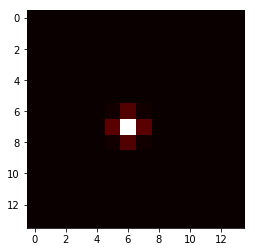

In [140]:
if __name__ == "__main__":
    h = DatasetWithHeatmap()
    h.createGazeHeatmap('/home/akanksha/Documents/Atari-HEAD-novice/4KD&AS/569_AS_4673908_Aug-01-10-41-22.asc')
    
    if np.count_nonzero(h.GHmap):
        print('GHmap is all zeros')
    
    GHmap=np.squeeze(h.GHmap)
    GHmap = GHmap[0,:,:]
#     print(GHmap)
    print(np.count_nonzero(GHmap))
    print(type(GHmap))
    print(GHmap.shape)
    
    plt.imshow(GHmap, cmap='hot', interpolation='nearest')
    plt.show()


/home/akanksha/.virtualenv/gym/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


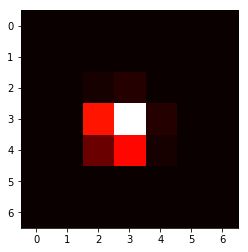

In [141]:
    # reshape a 14x14 heatmap to 7x7
    from skimage.transform import resize
    import scipy
    from scipy import interpolate
    GHmap = scipy.misc.imresize(GHmap, (7,7))
    
    plt.imshow(GHmap, cmap='hot', interpolation='nearest')
    plt.show()

In [142]:
    import atari_head_dataset as ahd
    from os import path, listdir
    import cv2
    
    env_name = 'breakout'
    g=env_name
    data_dir = '/home/akanksha/Documents/Atari-HEAD-novice/dummy_new/'
    dataset = ahd.AtariHeadDataset(env_name, data_dir)
    use_gaze=True
    mask = False

    traj_scores = []
    traj_dirs = []
    traj_gaze = []
    for t in dataset.trajectories[g]:
        print(len(dataset.trajectories[g][t]))
        traj_scores.append(dataset.trajectories[g][t][-1]['score'])
        traj_dirs.append(dataset.trajectories[g][t][-1]['img_dir'])
        traj_gaze.append([dataset.trajectories[g][t][i]['gaze_positions'] for i in range(len(dataset.trajectories[g][t]))])
        
        sorted_traj_scores = sorted(traj_scores)
        sorted_traj_dirs = [x for _, x in sorted(zip(traj_scores, traj_dirs), key=lambda pair: pair[0])]
        sorted_traj_gaze = [x for _, x in sorted(zip(traj_scores, traj_gaze), key=lambda pair: pair[0])]
    print(len(sorted_traj_gaze))
        
    seen_scores = set()
    non_duplicates = []
    for s,g,d in zip(sorted_traj_scores,sorted_traj_gaze,sorted_traj_dirs):
        if s not in seen_scores:
            seen_scores.add(s)
            non_duplicates.append((g,d))
            
    demos = non_duplicates
    
    human_gaze_26 = []
    human_gaze_11 = []
    human_gaze_7 = []
    
    i = 0
    
    print('len demos: ',len(demos))
    for gaze, img_dir in demos:
        traj_dir = path.join(data_dir, env_name, img_dir)
        
        if(use_gaze):
            # generate gaze heatmaps as per Ruohan's algorithm
            h = DatasetWithHeatmapFromList()
            g_26 = h.createGazeHeatmap(gaze, 26)
            g_11 = h.createGazeHeatmap(gaze, 11)
            g_7 = h.createGazeHeatmap(gaze, 7)
            
            if not np.count_nonzero(g_26):
                print('g_26 is all zeros')
                
#             if i==0:
#                 print(g_26)

            # skip and stack gaze
            maxed_gaze_26 = MaxSkipGaze(g_26, traj_dir, 26, i)
#             if i==0:
#                 print(maxed_gaze_26)
            stacked_gaze_26 = CollapseGaze(maxed_gaze_26, 26)
            
            human_gaze_26.append(stacked_gaze_26)

            maxed_gaze_11 = MaxSkipGaze(g_11, traj_dir, 11)
            stacked_gaze_11 = CollapseGaze(maxed_gaze_11, 11)
            human_gaze_11.append(stacked_gaze_11)

            maxed_gaze_7 = MaxSkipGaze(g_7, traj_dir, 7)
            stacked_gaze_7 = CollapseGaze(maxed_gaze_7, 7)
            human_gaze_7.append(stacked_gaze_7)
            
        i = i + 1

    if(use_gaze):    
        print(human_gaze_26[0][100].shape)
#         print(human_gaze_26[0][100])
        
    if not np.count_nonzero(human_gaze_26):
#         print(gaze_coords)
        print('The gaze map is all zeros')
#     print(human_gaze_26)
            
#     return human_gaze_26, human_gaze_11, human_gaze_7

    plt.imshow(human_gaze_26[0][100].squeeze(), cmap='hot', interpolation='nearest')
    plt.show()

env name:  breakout
valid trials: ['569_AS_4673908_Aug-01-10-41-22']
valid trial nums: [569]
1
569 [569]
randomly sampling a trial number for extra episodes in a trajectory
10733
2105
2
len demos:  2
[[[0.02585025 0.02585706 0.0130235  ... 0.         0.         0.        ]
  [0.08935319 0.08937672 0.04501664 ... 0.         0.         0.        ]
  [0.16889645 0.16894093 0.08509098 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.05131631 0.06555729 0.06063593 ... 0.         0.         0.        ]
  [0.05071007 0.05913193 0.04610462 ... 0.         0.         0.        ]
  [0.05399108 0.05624164 0.03266831 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.    

TypeError: MaxSkipGaze() missing 1 required positional argument: 'count'